In [1]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

## Generate Data

In [2]:

target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

In [3]:
rs = PSOOptim(c1=0.1, c2=0.3, w=0.9, n_iters=100, visualize=True, n_particles=10)
gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1, 1)))
gpr_rs.fit(X.T, y[...,None])
y_pred = gpr_rs.predict(X.T)

# x_grid, y_grid, z_grid = get_likelihood_grids(gpr_rs)
# rs.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO_vogel.mp4")

2022-08-05 16:39:51,116 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.1, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.41e+4
2022-08-05 16:39:52,678 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34147.105088368284, best pos: [-1.04154597 -1.09588239]


In [4]:
# from IPython.display import Video

# Video("PSO.mp4")

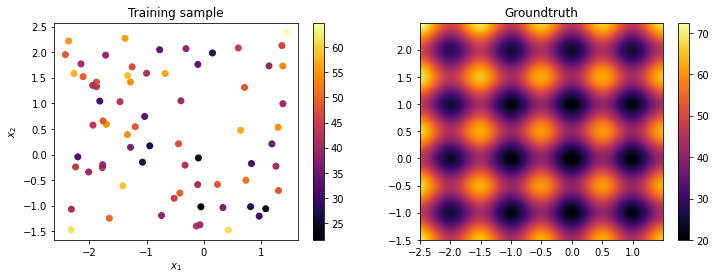

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(X[0], X[1], c=y, cmap="inferno")
plt.title("Training sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.colorbar()
plt.subplot(122)
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.show()

## GPR with Differential Evolution

In [6]:
optim = DEOptim()
gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,1)))
gpr_de.fit(X.T, y[...,None])
y_pred = gpr_de.predict(X.T)

In [7]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_de.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -34146.92764070165
          Mean Squared Error: 9.980443006678698e-17
          R2 Score: 1.0
          MAPE: 1.586868134462713e-10



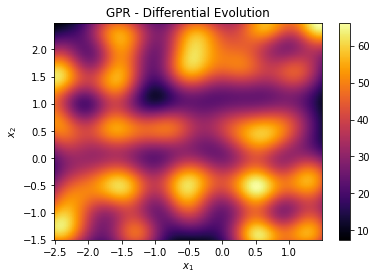

In [8]:
visualize_pred_meshgrid(gpr_de, "GPR - Differential Evolution")

In [9]:
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

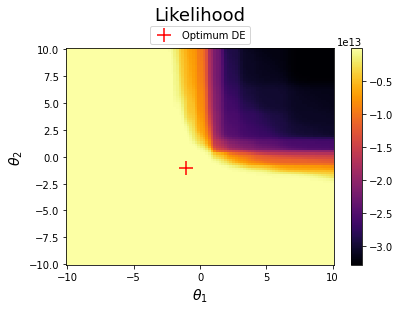

In [10]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum DE")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.1, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125, 0, 0))

In [11]:
n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

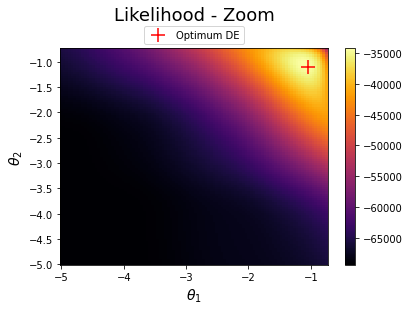

In [12]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum DE")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood - Zoom", y=1.1, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125, 0, 0))

## GPR with Random Search

In [13]:
rs = RandomOptim(maxiter=100, visualize=True)
gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
gpr_rs.fit(X.T, y[...,None])
y_pred = gpr_rs.predict(X.T)
# from utils_clean import get_likelihood_grids
# x, y, z = get_likelihood_grids(gpr_rs)
# rs.visualize_optimization(x, y, z, "Random Search.mp4")

In [14]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_rs.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -60232.37943734049
          Mean Squared Error: 1.9686274913765865e-16
          R2 Score: 1.0
          MAPE: 1.396860755724285e-10



In [15]:
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

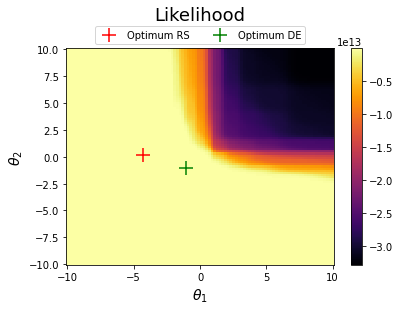

In [16]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.1, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125, 0, 0), ncol=2)

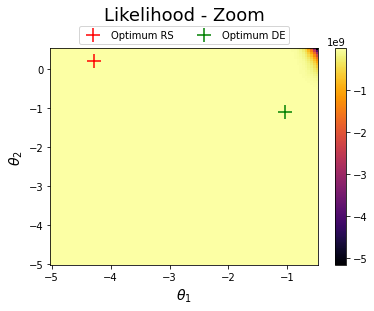

In [17]:
n = 100
x_grid = np.linspace(-5, -0.5, n)
y_grid = np.linspace(-5, 0.5, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood - Zoom", y=1.1, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125, 0, 0), ncol=2)

## GPR with PSO

In [18]:
pso = PSOOptim(n_iters=10, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=True)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
gpr_pso.fit(X.T, y[...,None])
y_pred = gpr_pso.predict(X.T)

2022-08-05 16:40:44,237 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.56e+4
2022-08-05 16:40:44,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35553.19896644657, best pos: [-0.95966569 -1.34520386]


In [19]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_pso.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -35553.19896644657
          Mean Squared Error: 6.166780069772583e-17
          R2 Score: 1.0
          MAPE: 1.2618154205238565e-10



In [20]:
gpr_pso.kernel_.theta

array([-0.95966569, -1.34520386])

In [21]:
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

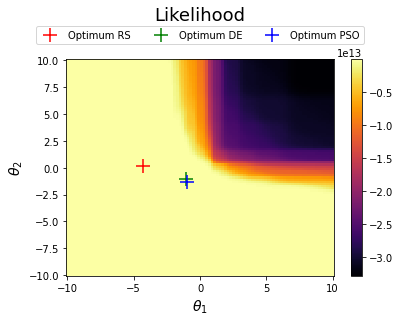

In [22]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)

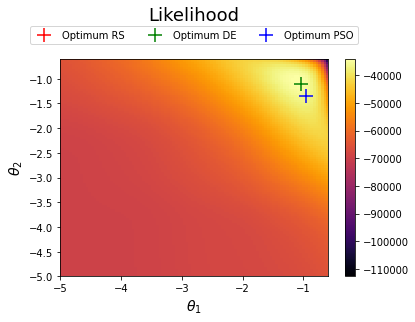

In [23]:
n = 100
x_grid = np.linspace(-5, -0.6, n)
y_grid = np.linspace(-5, -0.6, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.xlim(-5, -0.6)
plt.ylim(-5, -0.6)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)

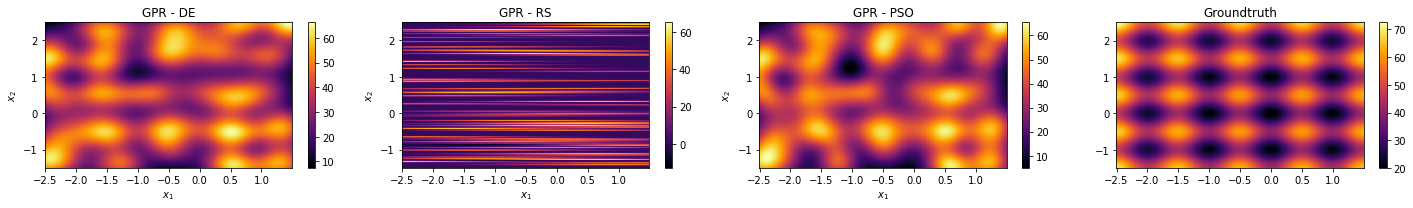

In [24]:
plt.figure(figsize=(20,3))
plt.subplot(141)
visualize_pred_meshgrid(gpr_de, "GPR - DE")
plt.subplot(142)
visualize_pred_meshgrid(gpr_rs, "GPR - RS")
plt.subplot(143)
visualize_pred_meshgrid(gpr_pso, "GPR - PSO")
plt.subplot(144)
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.tight_layout()
plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1148.00it/s]
2022-08-05 16:41:25,927 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2022-08-05 16:41:25,927 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


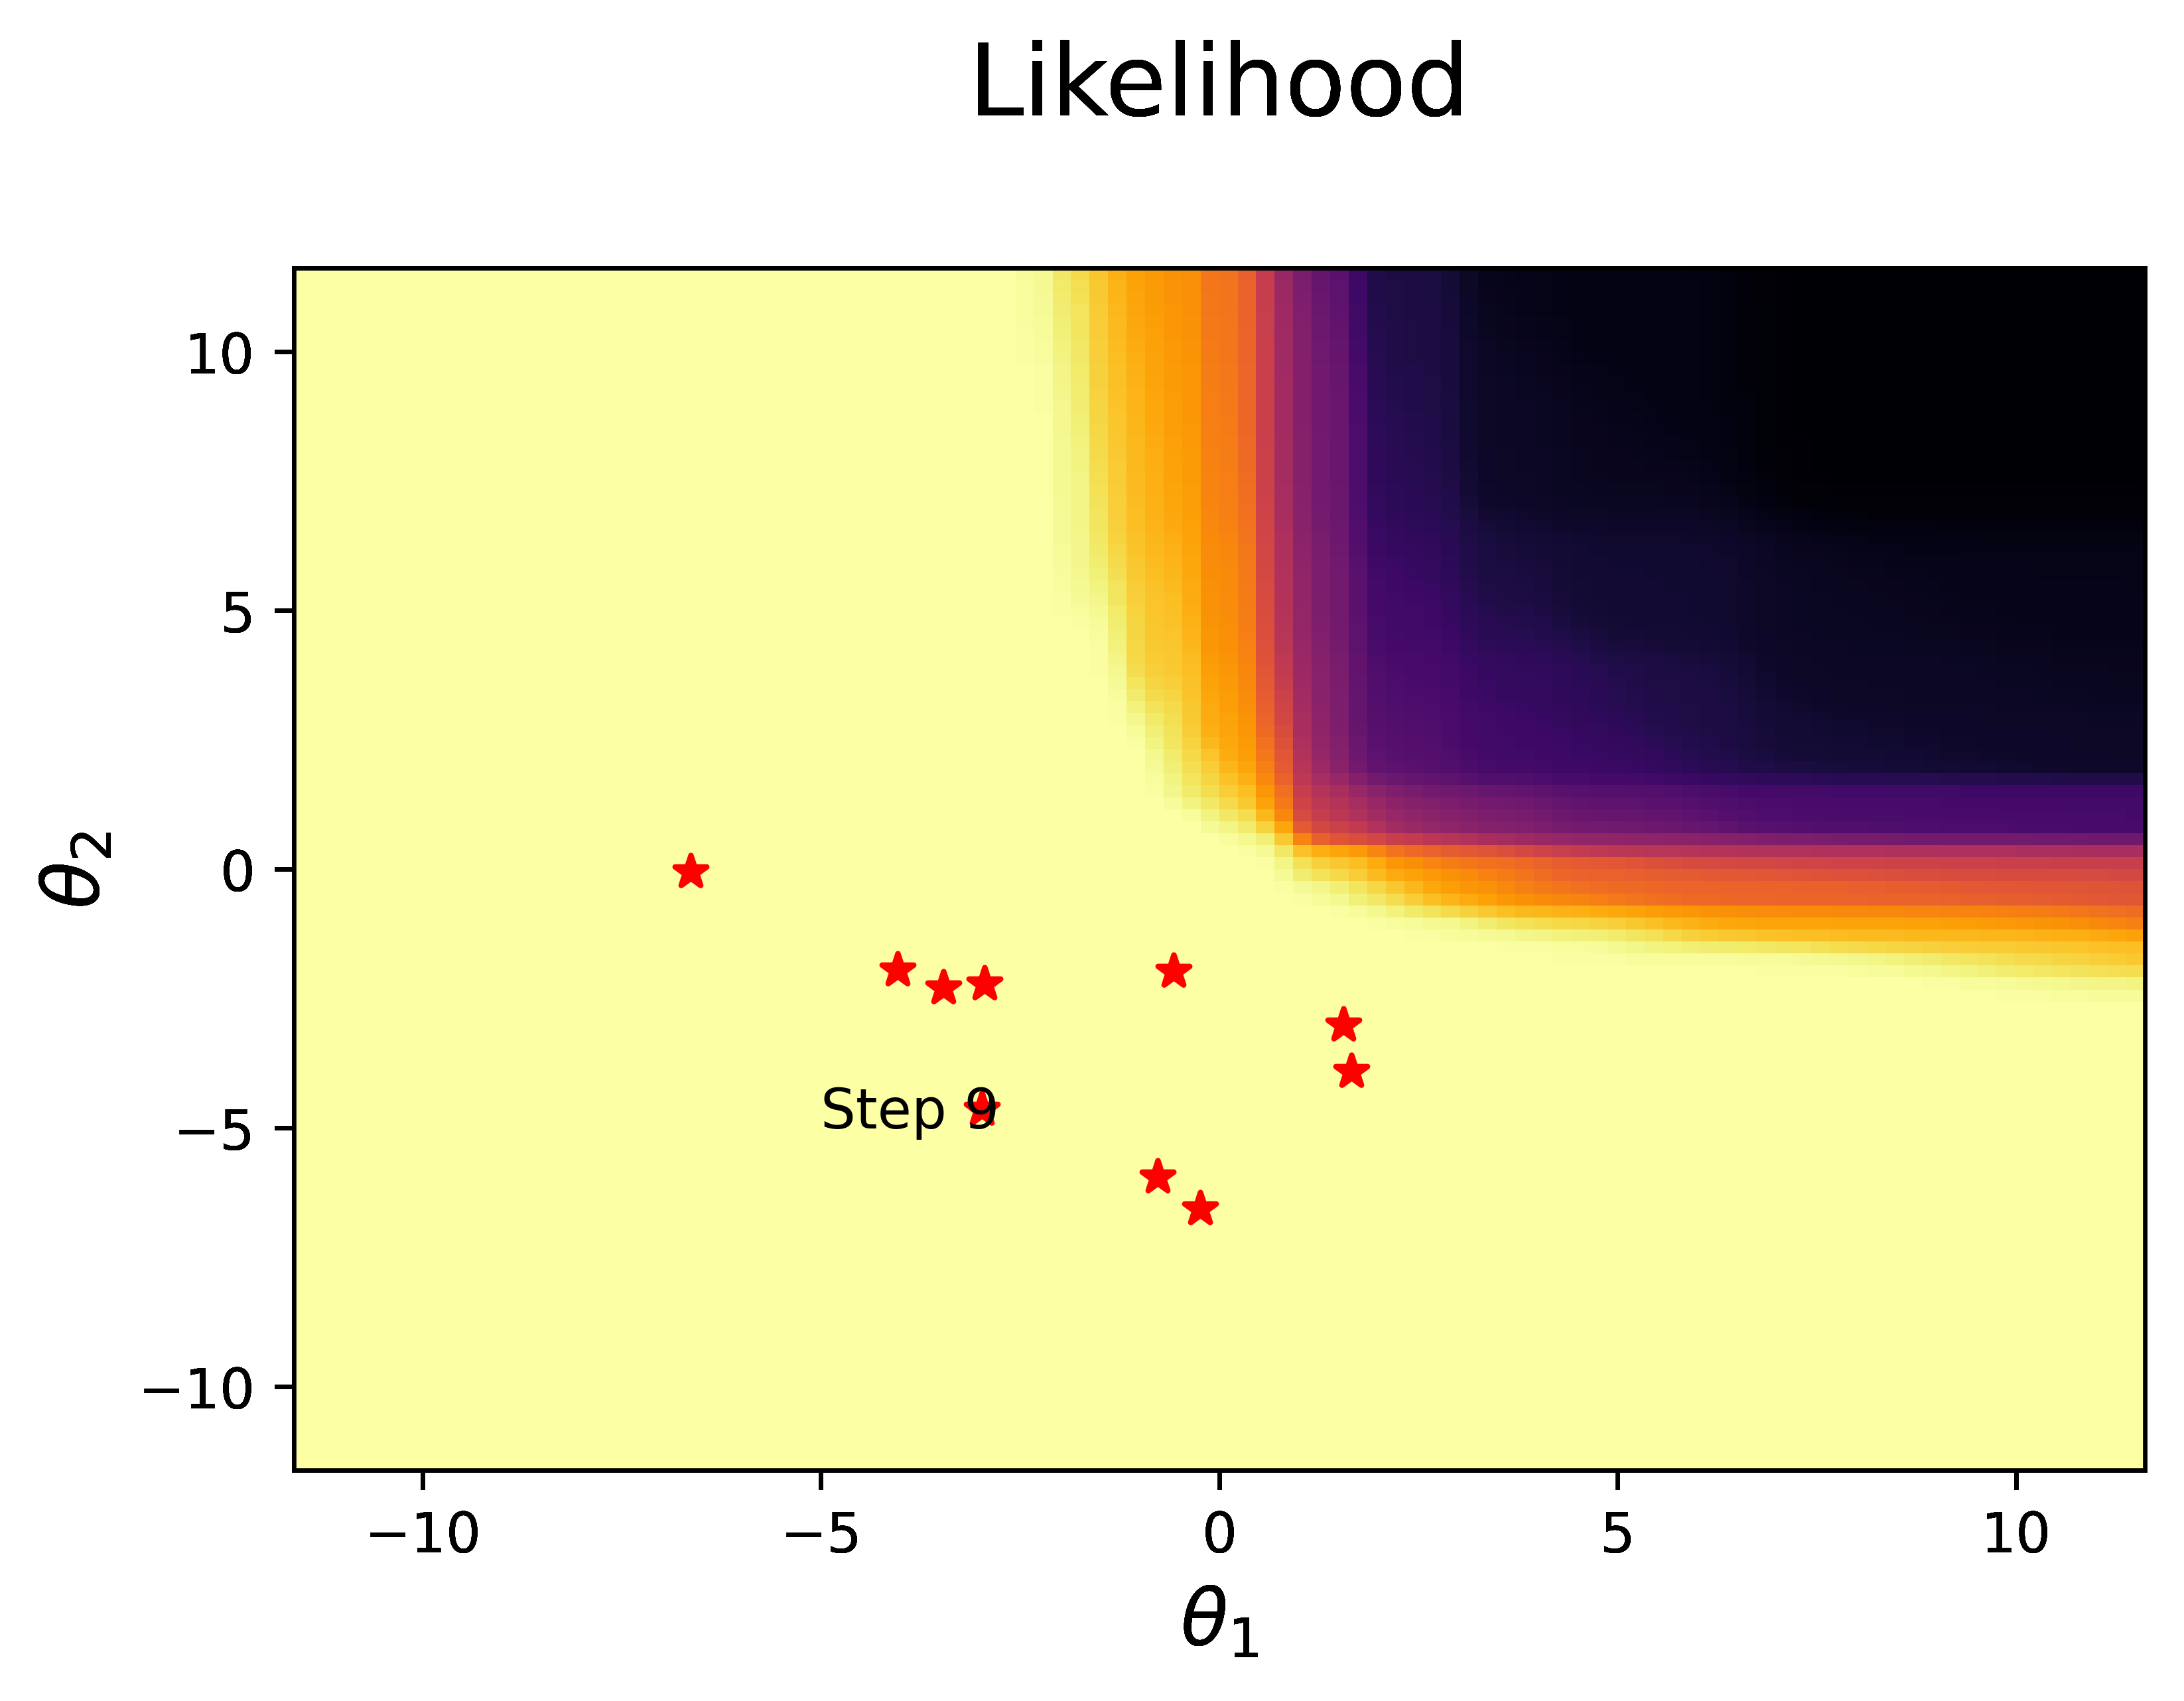

In [25]:
from utils_clean import get_likelihood_grids
x_grid, y_grid, z_grid = get_likelihood_grids(gpr_pso)
pso.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO.gif", show_zaeff=False)